In [87]:
try:
  import shap
except ModuleNotFoundError:
  !pip install shap
  import shap


In [88]:
import copy
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
import itertools
import re

# set plotting parameters from the beginning
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 14}
axes = {
        'titlesize' : 20,
        'labelsize' : 18}
figure = {'figsize':(6,4),
         'autolayout':True}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **axes)
matplotlib.rc('figure', **figure)

# Back to basics: linear regression & coefficients as importance


In [89]:
def simulate_model(*equations, nobs, seed):
  "Simulate a model by typing the equations as strings"
  np.random.seed(seed)
  data = {}
  for equation in equations:
      var, expr = equation.split('=')
      var = var.strip()
      #terms = expr.split('+')
      terms = re.split(' \+ | - ', expr)
      value = 0
      for term in terms:
        term = term.strip()
        if 'N(' in term and ')' in term:
            match = re.search('N\((.*),(.*)\)', term)
            if match:
                mean, variance = map(float, match.groups())
                value += mean + np.sqrt(variance)*np.random.randn(nobs)
        elif '*' in term:
            coef, var2 = term.split('*')
            coef = float(coef.strip())
            var2 = var2.strip()
            if var2 in data:
                value += coef * data[var2]
            else:
                raise ValueError(f"Variable {var2} not found")
        else:
            value += float(term)
      data[var] = value
      df = pd.DataFrame().from_dict(data, orient='index').T
  return df
print(simulate_model('x1 = 5 + N(0,0)', 'x2 = 10 + -3*x1 + N(0,0)', nobs=2, seed=1))

    x1   x2
0  5.0 -5.0
1  5.0 -5.0


### Linear regression

Let's compare two models:
$$
\begin{eqnarray}
y &=& \alpha + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \epsilon \\
y' &=& \alpha' + \beta'_1 x'_1 + \beta'_2 x'_2 + \beta'_3 x'_3 + \eta \\
\end{eqnarray}
$$

where _prime_ variables are standardized, eg. $x' = (x - mean(x))/std(x)$

We can replace the prime definitions in the second equation to get

$$
\begin{eqnarray}
y &=& \delta_0 + \delta_1 x_1 + \delta_2 x_2 + \delta_3 x_3 + \eta
\end{eqnarray}
$$

where
$$
\beta_k = \frac{s_y}{s_{x_k}}\beta'_k
$$




In [90]:
def run_regression_plots(xdf, ydf):
  # run a simple linear regression without standardizing the features
  reg = LinearRegression().fit(xdf, ydf)
  coef = reg.coef_
  # standardize first
  x_std = (xdf - xdf.mean())/xdf.std()
  y_std = (ydf - ydf.mean())/ydf.std()
  #print(f'Max abs mean = {round(np.abs(x_std.mean()).max(), 2)}, Max abs std = {np.abs(x_std.std()).max()}')
  reg_std = LinearRegression().fit(x_std, y_std)
  coef_std = reg_std.coef_.flatten()
  results_df = pd.DataFrame(coef.reshape(1,3), columns=xdf.columns, index=['Unstandardized'])
  results_df.loc['Standardized'] = coef_std
  # compute the exact coefficients from previous equation
  sy = ydf.std()
  sx = xdf.std().values
  prop_factor = sy/sx
  coef_ratio = coef/coef_std
  print("{:<30} {:<15} {:<15} {:<15} {:<15}".format("String", "Coef (1)", "Std Coef (2)", "(1)/(2)" ,"Sy/Sx"))
  for i in range(len(coef)):
    print("{:<30} {:<15} {:<15} {:<15} {:<15}".format(xdf.columns[i], round(coef[i],2), round(coef_std[i],2), round(coef_ratio[i],2), round(prop_factor[i],2)))

  # plot coefficients
  fig, ax = plt.subplots(1,2, figsize=(14,4))
  predf = (results_df.T.sort_values(by='Standardized', ascending=False)).T
  (predf).plot(kind='bar', ax = ax[0], edgecolor='k')
  xmin, xmax = ax[0].get_xlim()
  hl = ax[0].plot([xmin, xmax], [0,0], color='k')
  xl = ax[0].set_xlim([xmin, xmax])
  ax[0].set_title('Linear regression coefficients ')
  ax[0].set_xticklabels(results_df.index, rotation=0)
  # plot absolute value of coefficients
  absdf = (results_df.abs()).T
  #absdf_srt = absdf.sort_values(by='Standardized', ascending=False)
  absdf_srt = absdf
  (absdf_srt.T).plot(kind='bar', ax = ax[1], edgecolor='k')
  xmin, xmax = ax[1].get_xlim()
  hl = ax[1].plot([xmin, xmax], [0,0], color='k')
  xl = ax[1].set_xlim([xmin, xmax])
  ttl = ax[1].set_title('Absolute value of linreg coefficients')
  xtl = ax[1].set_xticklabels(absdf_srt.T.index, rotation=0)
  return fig, coef, coef_std

In [91]:
# I want to compute now the effect on predictive performance
# Strategy: compute mse for all combinations of features and then average out the effects
def fit_and_predict(model, x, y):
    model.fit(x, y)
    predictions = model.predict(x)
    return mean_squared_error(y, predictions)

def compute_mse_for_combinations(xdf, ydf, model):
    mse_dict = {'base': fit_and_predict(model, pd.DataFrame(np.ones(len(ydf))), ydf)}
    features = xdf.columns
    for r in range(1, len(features) + 1):
        for combination in itertools.combinations(features, r):
            mse = fit_and_predict(model, xdf[list(combination)], ydf)
            mse_dict[combination] = mse
    return mse_dict

def augment_mse_dict(mse_dict):
    for comb in [c for c in mse_dict.keys() if c != 'base' and len(c) > 1]:
        for new_perm in itertools.permutations(comb):
            if new_perm != comb:
                mse_dict[new_perm] = mse_dict[comb]
    return mse_dict

def calculate_marginal_mse(mse_df):
    mse_df['parent'] = mse_df['features'].apply(get_parent)
    parent_mse = mse_df.set_index('features')['mse'].to_dict()
    mse_df['parent_mse'] = mse_df['parent'].map(parent_mse)
    mse_df['marginal_mse'] = mse_df['mse'] - mse_df['parent_mse']
    return mse_df

def get_parent(features):
    if features == 'base' or len(features) == 1:
        return 'base'
    return features[:-1]

def calculate_average_marginal_mse(mse_df, features):
    avg_marginal_mse = {
        feature: mse_df[mse_df['features'].apply(lambda x: feature in x)]['marginal_mse'].mean()
        for feature in features
    }
    return pd.DataFrame.from_dict(avg_marginal_mse, orient='index', columns=['marginal_mse'])

def run_reg_combinations(xdf, ydf):
    model = LinearRegression()
    mse_dict = compute_mse_for_combinations(xdf, ydf, model)
    mse_dict = augment_mse_dict(mse_dict)
    mse_df = pd.DataFrame(list(mse_dict.items()), columns=['features', 'mse'])
    mse_df = calculate_marginal_mse(mse_df)
    df_mse_inc = calculate_average_marginal_mse(mse_df, xdf.columns)
    return mse_df, np.abs(df_mse_inc)



String                         Coef (1)        Std Coef (2)    (1)/(2)         Sy/Sx          
x1                             1.11            0.44            2.53            2.53           
x2                             -0.95           -0.4            2.41            2.41           
x3                             1.06            0.42            2.56            2.56           


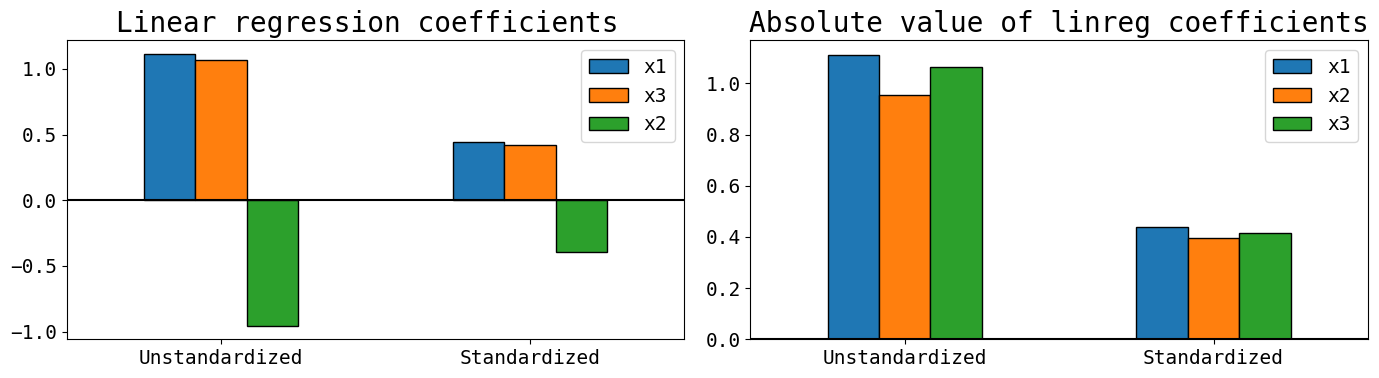

In [92]:
# Model 0: plain-vanilla model
eqs = ['x1 = N(0,1)',
       'x2 = N(0,1)',
       'x3 = 0*x2 + N(0,1)',
       'y = 3 + 1*x1 + -1*x2 + 1*x3 + N(0,3)']
data = simulate_model(*eqs, nobs=1000, seed=1)
ydf, xdf = data['y'] , data[data.columns[data.columns != 'y']]

# plot regression results
fig1, coef, coef_std = run_regression_plots(xdf, ydf)

String                         Coef (1)        Std Coef (2)    (1)/(2)         Sy/Sx          
x1                             1.11            0.36            3.07            3.07           
x2                             -0.95           -0.33           2.92            2.92           
x3                             1.03            0.67            1.55            1.55           


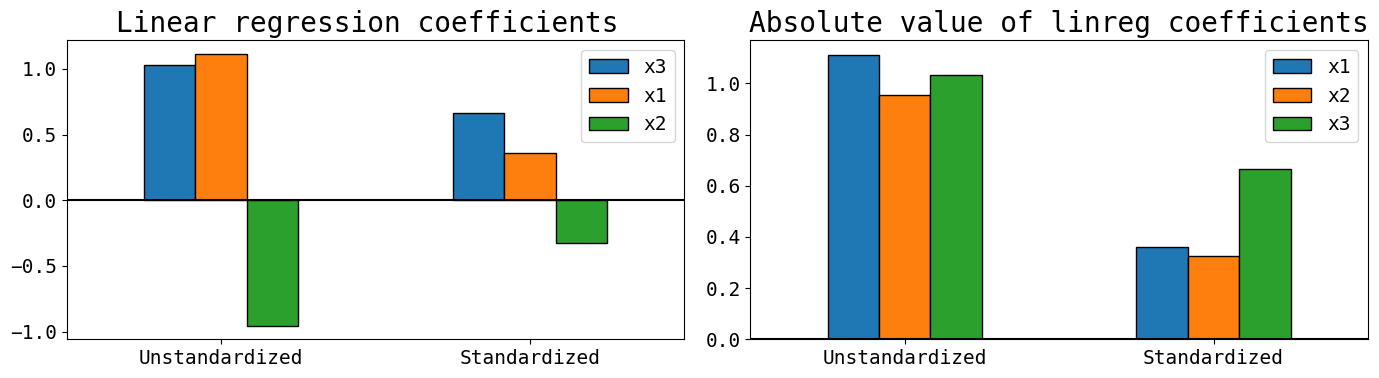

In [93]:
# increase variance of x3
eqs = ['x1 = N(0,1)',
       'x2 = N(0,1)',
       'x3 = 0*x2 + N(0,4)',
       'y = 3 + 1*x1 + -1*x2 + 1*x3 + N(0,3)']
data = simulate_model(*eqs, nobs=1000, seed=1)
ydf1, xdf1 = data['y'] , data[data.columns[data.columns != 'y']]
fig2 = run_regression_plots(xdf1, ydf1)

Now compute the impact on predictive performance

Impact of X3 = 30.187%


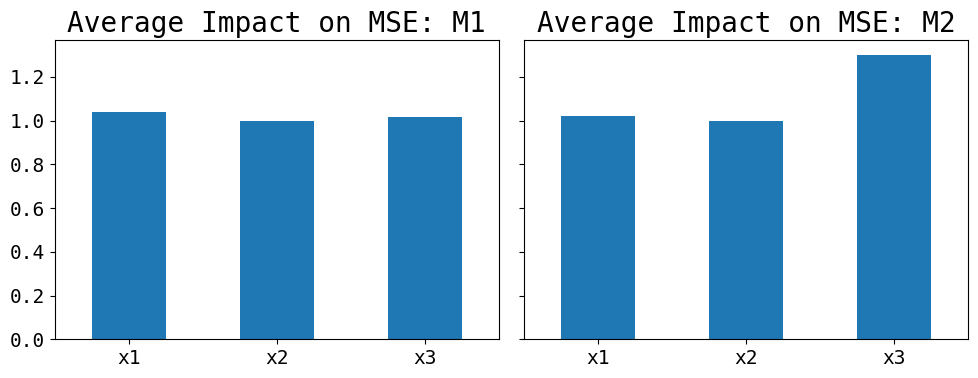

In [94]:
_, df_mse_inc = run_reg_combinations(xdf, ydf)
_, df_mse_inc1 = run_reg_combinations(xdf1, ydf1)
# normalize things
df_mse_inc1 /= df_mse_inc1.min()
df_mse_inc /= df_mse_inc.min()
inc_pct = 100*(df_mse_inc1.loc['x3'].marginal_mse-1)
print(f'Impact of X3 = {round(inc_pct, 3)}%')
titles = ['M1', 'M2']
fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True)
for i, dfi in enumerate([df_mse_inc, df_mse_inc1]):
  dfi.plot(kind='bar',ax=ax[i])
  ax[i].get_legend().remove()
  ax[i].set_title(f'Average Impact on MSE: {titles[i]}')
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=0)


Text(0.5, 0, 'Variance of X3')

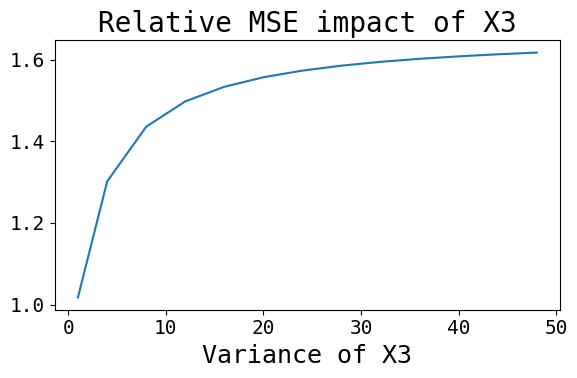

In [95]:
# I'm curious about how this grows as a function of variance
var_grid = [i for i in range(1,51) if i%4==0 or i==1]
dict_grid = {}
for v, var in enumerate(var_grid):
  eqs= ['x1 = N(0,1)',
       'x2 = N(0,1)',
       f'x3 = 0*x2 + N(0,{var})',
       'y = 3 + 1*x1 + -1*x2 + 1*x3 + N(0,3)']
  data = simulate_model(*eqs, nobs=1000, seed=1)
  ydfv, xdfv = data['y'] , data[data.columns[data.columns != 'y']]
  # regression and impact
  _, df_mse_incv = run_reg_combinations(xdfv, ydfv)
  # normalize things
  df_mse_incv /= df_mse_incv.min()
  dmse3 = df_mse_incv.loc['x3'].marginal_mse
  dict_grid[var] = dmse3

fig, ax = plt.subplots()
ax.plot(dict_grid.keys(), dict_grid.values())
ax.set_title('Relative MSE impact of X3')
ax.set_xlabel('Variance of X3')

## Other metrics of feature importance:

* Permutation
* Impurity
* Shapley values

In [96]:
# use SKLEARN permutation importance
reg = LinearRegression().fit(xdf, ydf)
pimp = permutation_importance(reg, xdf, ydf,n_repeats=100,random_state=0)
df_pimp = pd.DataFrame(pimp.importances.T, columns = xdf.columns)

In [97]:
def my_permutation_importance(model,xdf, ydf, size, seed, replace=True):
  "Compute permutation importance using the model score"
  np.random.seed(seed)
  # 1. Get the loss for base model
  base_score = model.score(xdf,ydf)
  # 2. make random permutations
  df_perm = pd.DataFrame(index=range(size), columns = xdf.columns, dtype='float')
  for k, col in enumerate(xdf.columns):
    xdf_cp = xdf.copy()
    for i in range(size):
      if replace: # draw with replacement
        xdf_cp[col] = xdf[col].sample(n=len(xdf), replace=True).values
      else:  # random permutation
        xdf_cp[col] = np.random.permutation(xdf[col].values)
      score_i = model.score(xdf_cp, ydf)
      df_perm[col].loc[i] = score_i
  delta_score = base_score - df_perm

  return delta_score

my_pimp = my_permutation_importance(model=reg,xdf=xdf, ydf=ydf, size=100, seed=0)

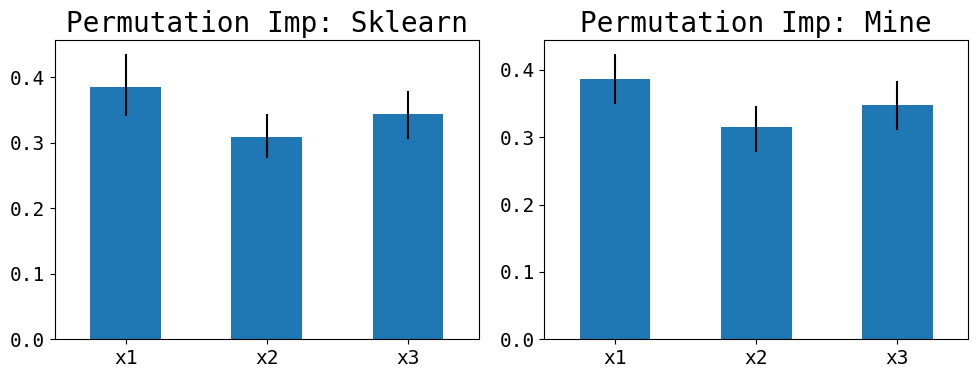

In [98]:
labs = ['Permutation Imp: Sklearn','Permutation Imp: Mine']
fig, ax = plt.subplots(1,2, figsize=(10,4))
for i, dfi in enumerate([df_pimp, my_pimp]):
  mean_i = dfi.mean()
  q_i = dfi.quantile([0.05, 0.95])
  mean_i.plot(kind='bar',ax=ax[i])
  for c, col in enumerate(dfi.columns):
    lc,hc = q_i[col].values
    ax[i].plot([c,c],[lc,hc], color='k')

  ax[i].set_title(labs[i])
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=0)


### Now let's train with a GBR

* I want to optimize metaparameters
  * Fix `max_depth` at 2
  * Optimize `n_estimators` and `learning_rate`
* I want to be as sure as possible that results are because of the algorithm and not because I didn't optimize metaparameters

In [99]:
# I want to simulate several models

# 1. Plain-vanilla: Model 1 above (everything is one, variances and slopes)
# 2. Variance: Model 2, has slopes=1 but Var(x3) = 4
# 3. Indirect effects: x2 --> x3, but doesn't affect y
# 4. Indirect + Direct effects x2-->x3 and x2-->y

# model 3: x2-->x3 but  NOT(x2-->y)
eqs3 = ['x1 = N(0,1)',
       'x2 = N(0,1)',
       'x3 = 1*x2 + N(0,1)',
       'y = 3 + 1*x1 + 0*x2 + 1*x3 + N(0,3)']
data = simulate_model(*eqs3, nobs=1000, seed=1)
y3, x3 = data['y'] , data[data.columns[data.columns != 'y']]

# model 4: x2-->x3 and x2--y
eqs4 = ['x1 = N(0,1)',
       'x2 = N(0,1)',
       'x3 = 1*x2 + N(0,1)',
       'y = 3 + 1*x1 + -1*x2 + 1*x3 + N(0,3)']
data = simulate_model(*eqs4, nobs=1000, seed=1)
y4, x4 = data['y'] , data[data.columns[data.columns != 'y']]


In [100]:
# Metaparameter optimization for all datasets
gbr = GradientBoostingRegressor()

# Metaparameters grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [200, 300, 400, 500,600]
}
# GridSearchCV
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gs_dict = {}
for d, data in enumerate([(xdf,ydf), (xdf1,ydf1),(x3,y3),(x4,y4)]):
  xd,yd = data
  grid_search.fit(xd, yd)
  bp = grid_search.best_params_
  bm = grid_search.best_score_
  print(f'Model({d}): best params = {bp}')
  print(f'Model({d}): mse: = {bm}')
  #save in dict
  gs_dict[d] = bp

Model(0): best params = {'learning_rate': 0.01, 'n_estimators': 400}
Model(0): mse: = -3.4228355179742236
Model(1): best params = {'learning_rate': 0.01, 'n_estimators': 500}
Model(1): mse: = -3.5245515936617595
Model(2): best params = {'learning_rate': 0.01, 'n_estimators': 300}
Model(2): mse: = -3.2735632870449187
Model(3): best params = {'learning_rate': 0.01, 'n_estimators': 500}
Model(3): mse: = -3.383196302346151


In [101]:
# store feature importances and permutation importances
dict_imp = {}
dict_per = {}
dict_sha = {}
for d, data in enumerate([(xdf,ydf), (xdf1,ydf1),(x3,y3),(x4,y4)]):
  xd, yd = data
  lr = gs_dict[d]['learning_rate']
  nt = gs_dict[d]['n_estimators']
  gbrd = GradientBoostingRegressor(random_state=0, learning_rate = lr, n_estimators = nt)
  gbrd.fit(xd, yd) # CAUTION: with real data I should be using test data
  # impurity based
  fi = gbrd.feature_importances_
  dict_imp[d] = fi
  # permutation based
  pi = my_permutation_importance(model=gbrd,xdf=xd, ydf=yd, size=100, seed=100)
  pm = pi.mean().values
  qi = pi.quantile([0.05, 0.95])
  dict_per[d] = [pm,qi]
  # shapley
  explainer = shap.Explainer(model=gbrd, xdf=xd)
  shap_values = explainer(xd).values
  fimp_sv = np.mean(np.abs(shap_values), axis=0)
  dict_sha[d] = fimp_sv



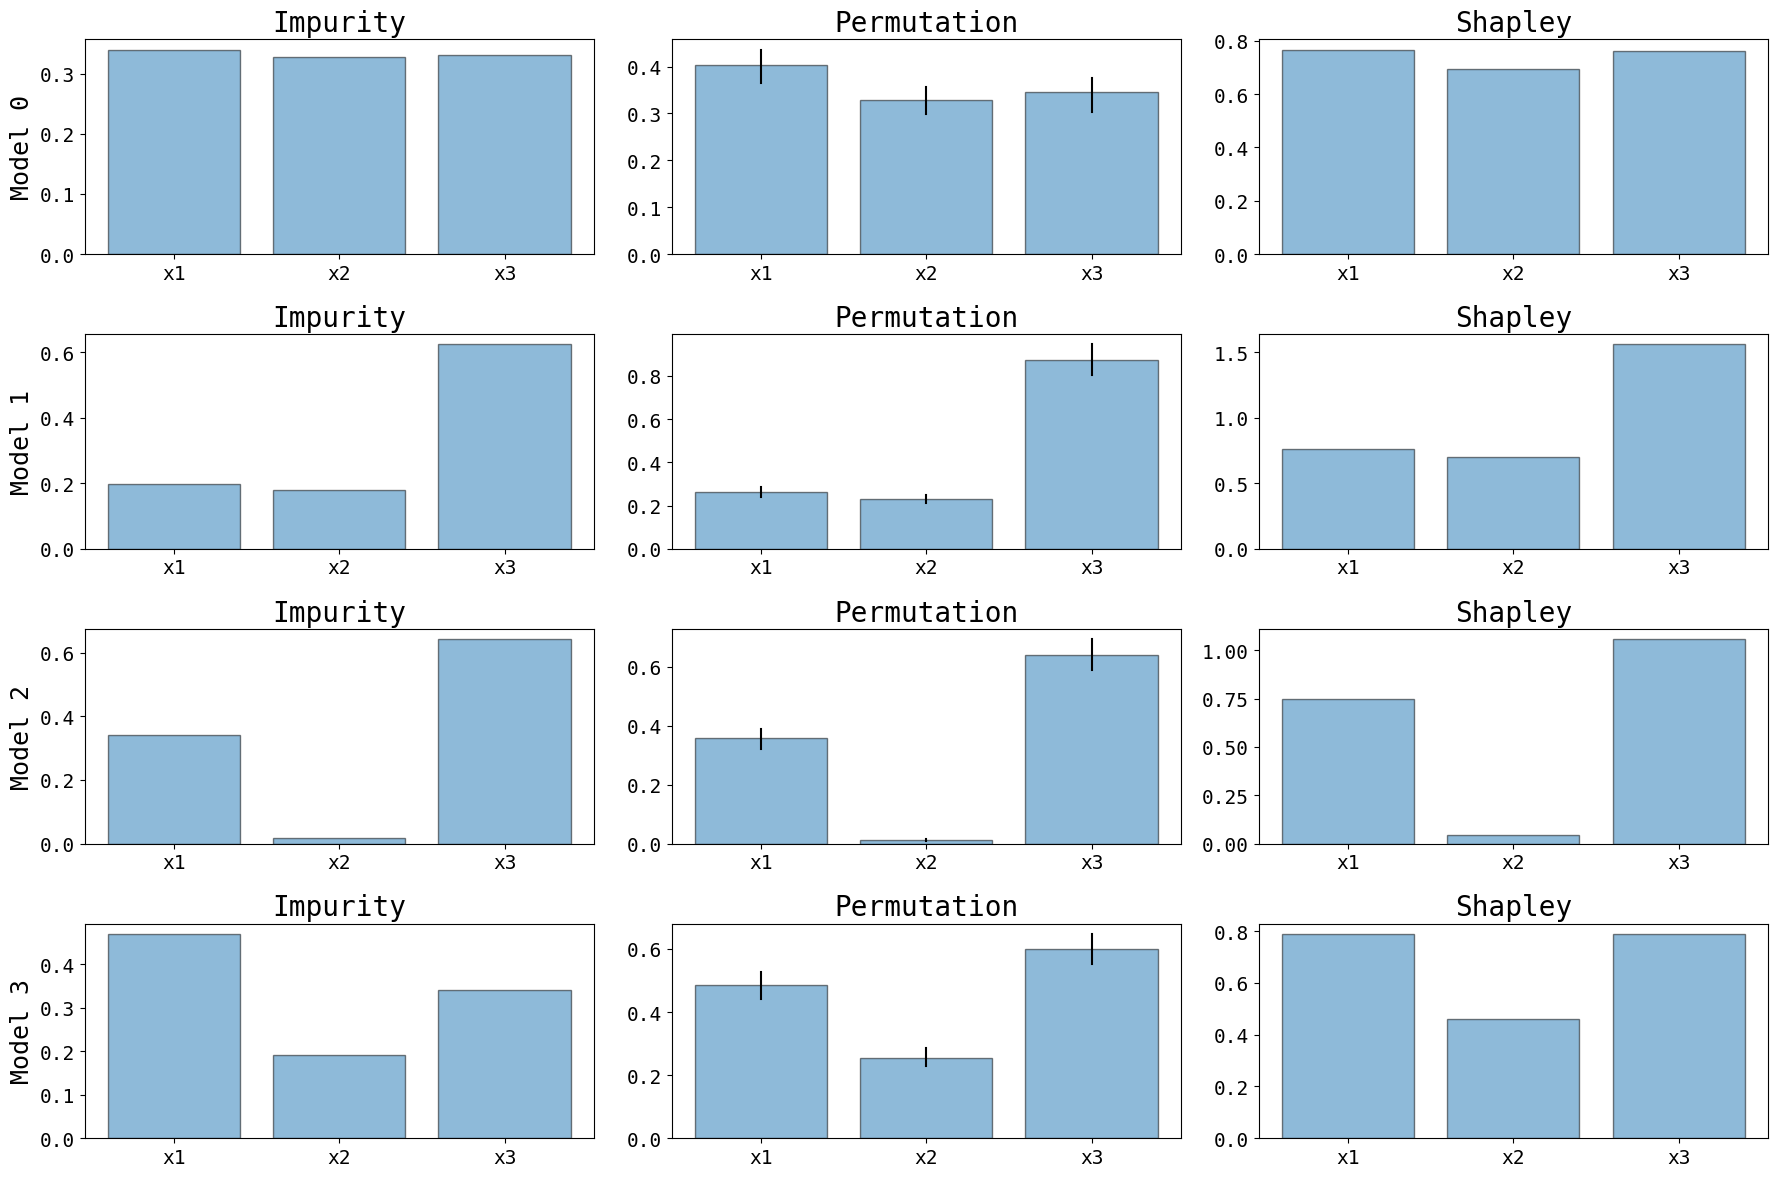

In [102]:
fig, ax = plt.subplots(4,3, figsize = (18,3*4))
ttl_lab = ['Impurity','Permutation','Shapley']
for i in range(4): # loop over datasets
  ib = dict_imp[i]
  pbm, pbq = dict_per[i]
  sb = dict_sha[i]
  ygrid = [ib,pbm,sb]
  xi = range(len(ib))
  for j in range(3):
    ax[i,j].bar(xi,ygrid[j], edgecolor='k', alpha=0.5)
    ax[i,j].set_xticks(xi)
    ax[i,j].set_xticklabels(['x1','x2','x3'])
    if j == 1:
      for k in range(3):
        low = pbq[pbq.columns[k]].loc[0.05]
        high = pbq[pbq.columns[k]].loc[0.95]
        ax[i,j].plot([xi[k],xi[k]],[low,high], color='k')
    ax[i,j].set_title(ttl_lab[j])
    if j==0:
      ax[i,j].set_ylabel(f'Model {i}')


### Test the last model with linear regression and Random Forest regression

* I want to show that both would provide results consistent with intuition

String                         Coef (1)        Std Coef (2)    (1)/(2)         Sy/Sx          
x1                             1.11            0.48            2.32            2.32           
x2                             -1.02           -0.46           2.21            2.21           
x3                             1.06            0.65            1.63            1.63           


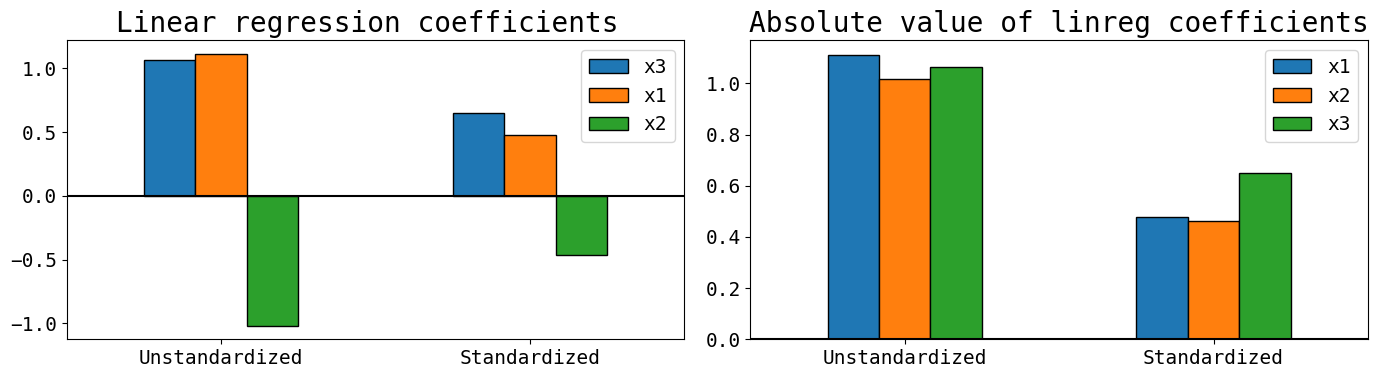

In [103]:
reg4 = run_regression_plots(xdf=x4, ydf=y4)

In [116]:
# Metaparameter optimization for all datasets
rfr = RandomForestRegressor()

# Metaparameters grid
param_grid = {
    'n_estimators': [25, 50, 100, 200,300],
    'max_depth' : [1,2,3,4,5,6,7,8,9]
}
# GridSearchCV
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(x4,y4)
print(f'RFR M3: best params = {grid_search.best_params_}')
print(f'RFR M3: best MSE = {grid_search.best_score_}')

RFR M3: best params = {'max_depth': 6, 'n_estimators': 200}
RFR M3: best MSE = -3.4338156843044536


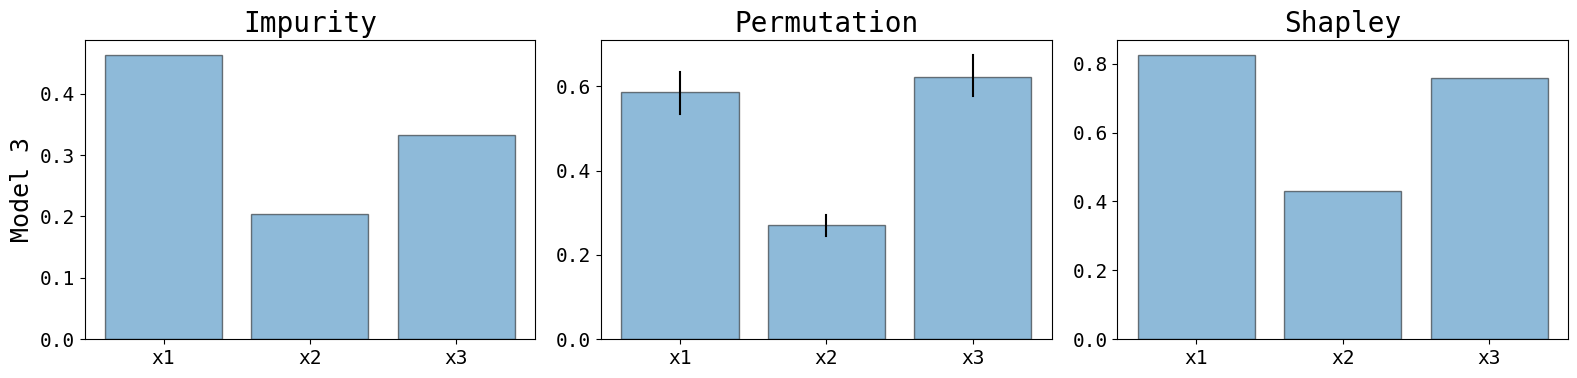

In [117]:
mdr = grid_search.best_params_['max_depth']
ner = grid_search.best_params_['n_estimators']
rfr = RandomForestRegressor(max_depth=mdr, n_estimators=ner, random_state=0).fit(x4,y4)
# impurity based
rfi = rfr.feature_importances_
# permutation based
rpi = my_permutation_importance(model=rfr,xdf=x4, ydf=y4, size=100, seed=100)
rpm = rpi.mean().values
rqi = rpi.quantile([0.05, 0.95])
# shapley
explainer = shap.Explainer(model=rfr, xdf=x4)
shap_values = explainer(x4).values
rfs = np.mean(np.abs(shap_values), axis=0)

fig, ax = plt.subplots(1,3, figsize=(16,4))
ygrid = [rfi,rpm,rfs]
xi = range(len(rfi))
for j in range(3):
  ax[j].bar(xi,ygrid[j], edgecolor='k', alpha=0.5)
  ax[j].set_xticks(xi)
  ax[j].set_xticklabels(['x1','x2','x3'])
  if j == 1:
    for k in range(3):
      low = rqi[rqi.columns[k]].loc[0.05]
      high = rqi[rqi.columns[k]].loc[0.95]
      ax[j].plot([xi[k],xi[k]],[low,high], color='k')
  ax[j].set_title(ttl_lab[j])
  if j==0:
    ax[j].set_ylabel(f'Model {i}')



## Let's do more optimization for GBR:

* Allow for more tree depth

In [ ]:
# Metaparameter optimization for all datasets
gbr = GradientBoostingRegressor()

# Metaparameters grid
param_grid = {
    'max_depth' : [2,3,4,5,6],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [200, 300, 400, 500,600]
}
# GridSearchCV
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gs_dict = {}
for d, data in enumerate([(xdf,ydf), (xdf1,ydf1),(x3,y3),(x4,y4)]):
  xd,yd = data
  grid_search.fit(xd, yd)
  bp = grid_search.best_params_
  bm = grid_search.best_score_
  print(f'Model({d}): best params = {bp}')
  print(f'Model({d}): mse: = {bm}')
  #save in dict
  gs_dict[d] = bp

Model(0): best params = {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400}
Model(0): mse: = -3.420595373020427
Model(1): best params = {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 400}
Model(1): mse: = -3.503280473447943
Model(2): best params = {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 600}
Model(2): mse: = -3.225237694947954


In [ ]:
# store feature importances and permutation importances
dict_imp = {}
dict_per = {}
dict_sha = {}
for d, data in enumerate([(xdf,ydf), (xdf1,ydf1),(x3,y3),(x4,y4)]):
  xd, yd = data
  lr = gs_dict[d]['learning_rate']
  nt = gs_dict[d]['n_estimators']
  md = gs_dict[d]['max_depth']
  gbrd = GradientBoostingRegressor(random_state=0, learning_rate = lr, n_estimators = nt, max_depth = md)
  gbrd.fit(xd, yd) # CAUTION: with real data I should be using test data
  # impurity based
  fi = gbrd.feature_importances_
  dict_imp[d] = fi
  # permutation based
  pi = my_permutation_importance(model=gbrd,xdf=xd, ydf=yd, size=100, seed=100)
  pm = pi.mean().values
  qi = pi.quantile([0.05, 0.95])
  dict_per[d] = [pm,qi]
  # shapley
  explainer = shap.Explainer(model=gbrd, xdf=xd)
  shap_values = explainer(xd).values
  fimp_sv = np.mean(np.abs(shap_values), axis=0)
  dict_sha[d] = fimp_sv



In [ ]:
fig, ax = plt.subplots(4,3, figsize = (18,3*4))
ttl_lab = ['Impurity','Permutation','Shapley']
for i in range(4): # loop over datasets
  ib = dict_imp[i]
  pbm, pbq = dict_per[i]
  sb = dict_sha[i]
  ygrid = [ib,pbm,sb]
  xi = range(len(ib))
  for j in range(3):
    ax[i,j].bar(xi,ygrid[j], edgecolor='k', alpha=0.5)
    ax[i,j].set_xticks(xi)
    ax[i,j].set_xticklabels(['x1','x2','x3'])
    if j == 1:
      for k in range(3):
        low = pbq[pbq.columns[k]].loc[0.05]
        high = pbq[pbq.columns[k]].loc[0.95]
        ax[i,j].plot([xi[k],xi[k]],[low,high], color='k')
    ax[i,j].set_title(ttl_lab[j])
    if j==0:
      ax[i,j].set_ylabel(f'Model {i}')
